In [1]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

# Cahn-Hilliard equation

The free-energy is defined as 

$$ F[c] = \int_V dx \left[ \frac{\kappa}{2}\left(\nabla c\right)^2 +f(c) \right]$$

where the free-energy density is

$$f(c) = W c^2(1-c)^2$$

The conservation equation is obtained by the flux $\boldsymbol{j} = -M \nabla(\delta F/\delta c)$, such that

$$\frac{\partial c}{\partial t} = M \left[ - \kappa \nabla^4 c+ \nabla^2 f'  \right] $$

onde $f' = df/dc$

In [13]:
import numpy as np
from scipy.fft import fft2, ifft2
# Cahn-Hilliard model constants
W = 2.0
M = 1.0 # mobility
kappa = 0.5 #gradient coeficient
# The derivative of bulk free energy density
def dfdn(n):
    return 2*W*(n*(1-n)**2-(1-n)*n**2)
# Size of the system
dx = 1.0
N = 2**8 # 2**8 = 256
x = np.linspace(0,N*dx,N)
# The time step definition
dt = 0.2
T = 3000
Nsteps = int(T/dt)
# The vector of variables
n_hat = np.empty((N,N), dtype=np.complex64)
n = np.empty((Nsteps,N,N), dtype=np.float32)
# Initial condition
rng = np.random.default_rng(12345)
noise = 0.02
n0 = 0.4
n[0] = n0 + noise*rng.standard_normal(n[0].shape)
# The Fourier variables and dealising vector
kx = np.fft.fftfreq(N, d=dx)*2*np.pi
k = np.array(np.meshgrid(kx , kx ,indexing ='ij'), dtype=np.float32)
k2 = np.sum(k*k,axis=0, dtype=np.float32)
kmax_dealias = kx.max()*2.0/3.0 # The Nyquist mode
dealias = np.array((np.abs(k[0]) < kmax_dealias )*(np.abs(k[1]) < kmax_dealias ),dtype =bool)
# The linear terms of PDE
linear_terms_ft = -M*kappa*k2**2
# The non-linear terms of PDE (with dealising)
def nonlinear_terms_ft(n):
    return (-k2*M*fft2(dfdn(n)))*dealias
# Defining the time derivative arrays
dndtlinear_hat = np.exp(dt*linear_terms_ft) # can be calculated once
dndtnonlinear_hat = n_hat.copy()
# time evolution loop
n_hat[:] = fft2(n[0]) # FT initial condition
for i in range(1,Nsteps):
    dndtnonlinear_hat[:] = nonlinear_terms_ft(n[i-1]) # calculate the non-linear term
    n_hat[:] = (n_hat+dt*dndtnonlinear_hat)*dndtlinear_hat # updating in time
    n[i] = ifft2(n_hat).real # IFT to next step

In [14]:
L = N*dx

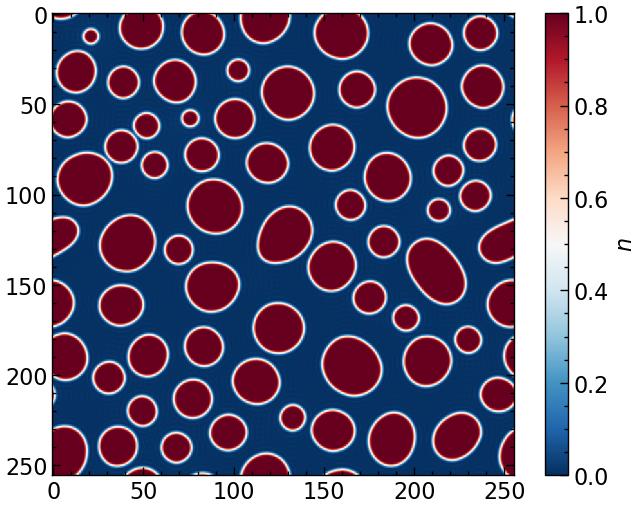

In [15]:
plt.imshow(n[-1],cmap='RdBu_r', vmin=0.0, vmax=1.0)
plt.colorbar(label=r'$n$')

In [16]:
100/dt

500.0

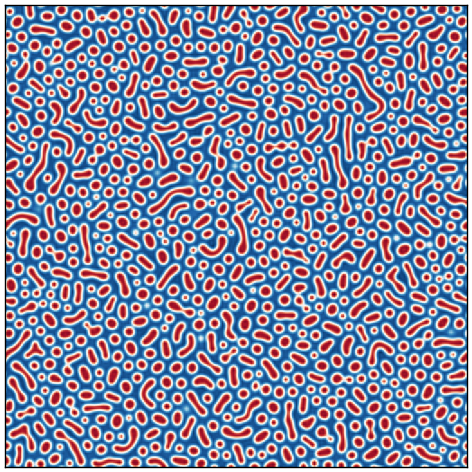

In [17]:
plt.imshow(n[99],cmap='RdBu_r')
plt.xticks([])
plt.yticks([])
plt.savefig('cahnhilliard2d-n0='+str(n0)+'-t=10.pdf')

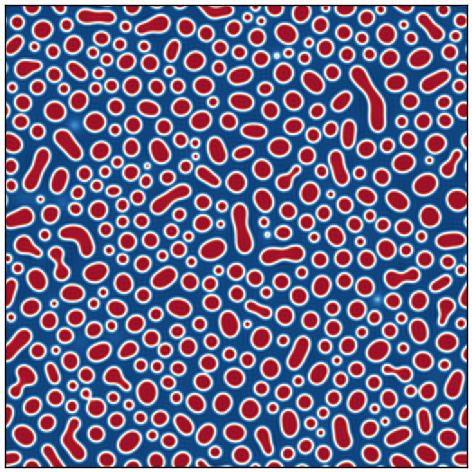

In [18]:
plt.imshow(n[499],cmap='RdBu_r')
plt.xticks([])
plt.yticks([])
plt.savefig('cahnhilliard2d-n0='+str(n0)+'-t=100.pdf')

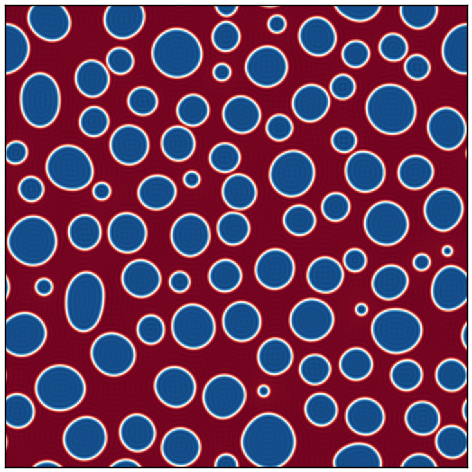

In [8]:
plt.imshow(n[9999],cmap='RdBu_r')
plt.xticks([])
plt.yticks([])
plt.savefig('cahnhilliard2d-n0='+str(n0)+'-t=1000.pdf')

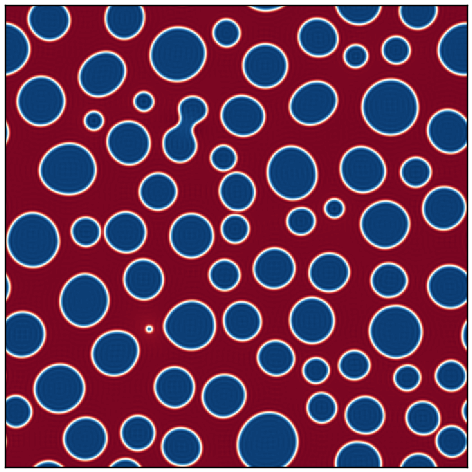

In [9]:
plt.imshow(n[-1],cmap='RdBu_r')
plt.xticks([])
plt.yticks([])
plt.savefig('cahnhilliard2d-n0='+str(n0)+'-t=3000.pdf')

In [10]:
print(n[0].sum()*dx**2/L**2,n[-1].sum()*dx**2/L**2)

0.5000993013381958 0.5000993013381958


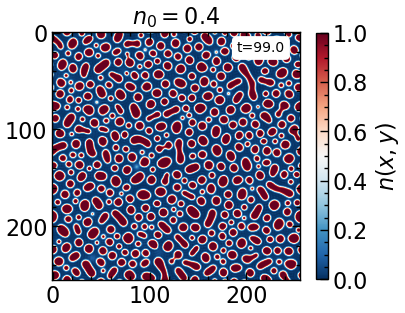

In [9]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

fig, ax = plt.subplots(1,1,figsize=(4,4))
im = ax.imshow(n[0],cmap='RdBu_r', vmin=0.0, vmax=1.0)
cb = fig.colorbar(im,ax=ax, label=r'$n(x,y)$', shrink=0.8)
tx = ax.text(190,20,'t={:.1f}'.format(0.0),
         bbox=dict(boxstyle="round",ec='white',fc='white'))
ax.set_title(r'$n_0=%.1f$'% n0)

def animate(i):
    im.set_data(n[5*i])
    im.set_clim(0.0, 1.0)
    tx.set_text('t={:.1f}'.format(5*i*dt))
    return fig,

ani = animation.FuncAnimation(fig, animate, frames= 199,
                               interval = 50)
ani.save('cahnhilliard2d-n0='+str(n0)+'.gif',writer='pillow',fps=30,dpi=200)

## Semi-implicit method

In [5]:
nsemi = np.empty((Nsteps,N,N), dtype=np.float32)
nsemi[0] = n[0]
dndtlinear_hat = 1.0/(1.0-dt*linear_terms_ft) # can be calculated once
dndtnonlinear_hat = n_hat.copy()
# time evolution loop
n_hat[:] = fft2(nsemi[0]) # FT initial condition
for i in range(1,Nsteps):
    dndtnonlinear_hat[:] = nonlinear_terms_ft(nsemi[i-1]) # calculate the non-linear term
    n_hat[:] = (n_hat+dt*dndtnonlinear_hat)*dndtlinear_hat # updating in time
    nsemi[i] = ifft2(n_hat).real # IFT to next step

In [6]:
print(nsemi[0].sum()*dx**2/L**2,nsemi[-1].sum()*dx**2/L**2)

0.4001249670982361 0.4001249670982361


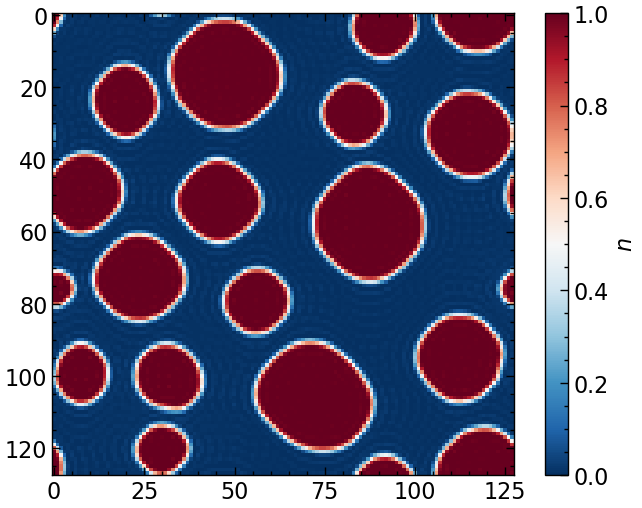

In [7]:
plt.imshow(nsemi[-1],cmap='RdBu_r', vmin=0.0, vmax=1.0)
plt.colorbar(label=r'$n$')

In [20]:
def fbulk(c):
    return W*c**2*(1-c)**2

In [21]:
F = np.zeros(Nsteps)
Fsemi = np.zeros(Nsteps)
t = np.linspace(0.0,Nsteps*dt,Nsteps)
nablacx = np.empty((N,N), dtype=np.float32)
nablacy = np.empty((N,N), dtype=np.float32)
for i in range(Nsteps):
    n_hat[:] = fft2(n[i])
    nablacx[:] = ifft2(1.0j*kx*n_hat).real
    nablacy[:] = ifft2(1.0j*kx*n_hat).real
    F[i] = np.sum(0.5*kappa*(nablacx*nablacx+nablacy*nablacy)+fbulk(n[i]))*dx**2
    
#     n_hat[:] = fft2(nsemi[i])
#     nablacx[:] = ifft2(1.0j*kx*n_hat).real
#     nablacy[:] = ifft2(1.0j*kx*n_hat).real
#     Fsemi[i] = np.sum(0.5*kappa*(nablacx*nablacx+nablacy*nablacy)+fbulk(nsemi[i]))*dx**2

Text(0, 0.5, '$F[n]/L^2$')

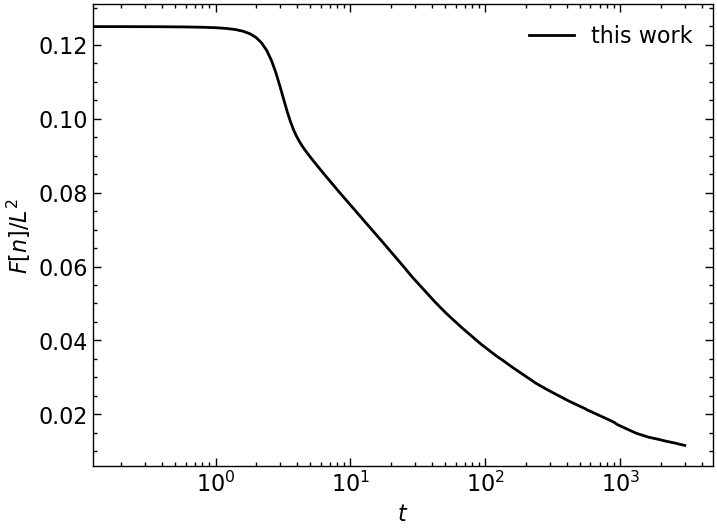

In [23]:
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(0,100)
# plt.ylim(0.1,1)
# plt.plot(t,Fsemi/L**2,'--',label='semi-implicit')
plt.plot(t,F/L**2,'k',label='this work')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$F[n]/L^2$')